In [16]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
import os
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt

In [17]:
def fusion(global_features,local_features,order_first="local"):
    """when you apply just the sequeeze() it removes all the ones
    #so (1,2048,1,1) after squeezing -> (2048), adding that extra dimension on the zero 
    #axis :- unsqueeze(0) (1,2048)"""
    
    if order_first=="local":
        if global_features.shape[0]==1:
            x = torch.cat([local_features,global_features],axis=1).squeeze().unsqueeze(0)
        else: #if we have batch size!=1, then we dont have to unsqueeze because it wont squeeze the batch size       
            x = torch.cat([local_features,global_features],axis=1).squeeze()
        return x
    else:#stack global first
        if global_features.shape[0]==1:
            x = torch.cat([global_features,local_features],axis=1).squeeze().unsqueeze(0)
        else:#if we have batch size!=1, then we dont have to unsqueeze     
            x = torch.cat([global_features,local_features],axis=1).squeeze()
        return x

In [11]:
global_matrix = torch.randn(20,2048,1,1)
local_matrix = torch.randn(20,2048,1,1)

In [12]:
fusion(global_matrix,local_matrix,order_first="global").size()

torch.Size([20, 4096])

In [18]:
df = pd.read_csv("FIR/advanced_ir/data.csv")

In [6]:
cd ..

/home/jovyan


first CPH length: 6595 second
SF length: 4525

In [19]:
def rank(local_features_cph_query,global_features_cph_query,
         local_features_sf_query,global_features_sf_query,
         local_features_cph_database,global_features_cph_database,
         local_features_sf_database,global_features_sf_database,df):
    
    CPH_LEN = 6595
    SF_LEN = 4525
    for row in range(df.shape[0]):    

        if row<CPH_LEN:
            #unsqueezing because when we access it we result in ([2048]), to make it ([1,2048])
            #same for global
            local_feature_query = local_features_cph_query[row].unsqueeze(0)
            global_feature_query = global_features_cph_query[row].unsqueeze(0)
            
            #applying the fusion (1,4096)
            query_fusion = fusion(global_feature_query,local_feature_query)
            #eval basically converts to the required datatype given the string format
            retrieved_indices = eval(df.iloc[row]["retrieved_indicies"])
            database_feature_list = None
            #fetching all the features first and concatenating them
            for database_id in retrieved_indices:
                #same reason as above(to why we unsqueezing)
                global_feature_database = global_features_cph_database[database_id].unsqueeze(0)
                
                local_feature_database = local_features_cph_database[database_id].unsqueeze(0)
                #(1,4096)
                combined_features = fusion(global_feature_database,local_feature_database)
                if database_feature_list is None:
                    database_feature_list = combined_features
                else:
                    database_feature_list = torch.cat([database_feature_list,combined_features])
            #so now we result the size of database_feature_list as -> (top_k,4096)
            #computing the similarity so we get (1,top_k) size. 1 because, 1 query image passed in
            similarity = cosine_similarity(query_fusion,database_feature_list)
            #getting the indices of the most similar and mapping to the retrieved list
            ranked_indices = [retrieved_indices[i] for i in np.argsort(similarity)[0]]
      
            df.loc[row,"re_ranked"] = str(ranked_indices)

        else: #For SF
            
            row = abs(row-CPH_LEN) 
            
            local_feature_query = local_features_sf_query[row].unsqueeze(0)
            global_feature_query = global_features_sf_query[row].unsqueeze(0)

            query_fusion = fusion(global_feature_query,local_feature_query)
        
            retrieved_indices = eval(df.iloc[CPH_LEN+row]["retrieved_indicies"])

            
            database_feature_list = None
            
            for database_id in retrieved_indices:
          
                global_feature_database = global_features_sf_database[database_id].unsqueeze(0)
                
                local_feature_database = local_features_sf_database[database_id].unsqueeze(0)
                combined_features = fusion(global_feature_database,local_feature_database)
                
                if database_feature_list is None:
                    database_feature_list = combined_features
                else:
                    database_feature_list = torch.cat([database_feature_list,combined_features])
            
            similarity = cosine_similarity(query_fusion,database_feature_list)
            ranked_indices = [retrieved_indices[i] for i in np.argsort(similarity)[0]]
            
            df.loc[CPH_LEN+row,"re_ranked"] = str(ranked_indices)
    
    return df

In [20]:
DATA_ROOT = "FIR"
DIR_ADVANCED_IR = os.path.join(DATA_ROOT, "advanced_ir") #i added the local features into a folder 'weights' in advanced_ir
DATASET_ROOT = os.path.join(DATA_ROOT, "msls")
DATASET_TEST = os.path.join(DATASET_ROOT, "test")
DATASET_VAL = os.path.join(DATASET_ROOT, "train_val")
DATASET_VAL_SF = os.path.join(DATASET_VAL, "sf")
DATASET_VAL_CPH = os.path.join(DATASET_VAL, "cph")

In [21]:
local_features_cph_query = torch.from_numpy(np.load(os.path.join(DIR_ADVANCED_IR,"weights/MSLS_resnext_GCL_multi_attrous_attention_map_cph_local_queryfeats.npy")))
global_features_cph_query =  torch.from_numpy(np.load(os.path.join(DATA_ROOT,"results/MSLS/val/MSLS_resnext_GeM_480_GCL_cph_queryfeats.npy")))

local_features_sf_query =  torch.from_numpy(np.load(os.path.join(DIR_ADVANCED_IR,"weights/MSLS_resnext_GCL_multi_attrous_attention_map_sf_local_queryfeats.npy")))
global_features_sf_query =  torch.from_numpy(np.load(os.path.join(DATA_ROOT,"results/MSLS/val/MSLS_resnext_GeM_480_GCL_sf_queryfeats.npy")))

local_features_cph_database =  torch.from_numpy(np.load(os.path.join(DIR_ADVANCED_IR,"weights/MSLS_resnext_GCL_multi_attrous_attention_map_cph_local_mapfeats.npy")))
global_features_cph_database =  torch.from_numpy(np.load(os.path.join(DATA_ROOT,"results/MSLS/val/MSLS_resnext_GeM_480_GCL_cph_mapfeats.npy")))

local_features_sf_database =  torch.from_numpy(np.load(os.path.join(DIR_ADVANCED_IR,"weights/MSLS_resnext_GCL_multi_attrous_attention_map_sf_local_mapfeats.npy")))
global_features_sf_database =  torch.from_numpy(np.load(os.path.join(DATA_ROOT,"results/MSLS/val/MSLS_resnext_GeM_480_GCL_sf_mapfeats.npy")))

In [10]:
local_features_sf_query.shape

(4525, 2048)

In [17]:
local_features_sf_query[0].shape

(2048,)

In [8]:
global_features_sf_database.shape

(6315, 2048)

In [26]:
# #simulation 


# local_features_cph_query = torch.randn(6595,2048)
# global_features_cph_query = torch.randn(6595,2048)

# local_features_sf_query = torch.randn(4525,2048)
# global_features_sf_query = torch.randn(4525,2048)

# local_features_cph_database = torch.randn(20000,2048)
# global_features_cph_database = torch.randn(20000,2048)

# local_features_sf_database = torch.randn(20000,2048)
# global_features_sf_database = torch.randn(20000,2048)

In [22]:
new_df = rank(local_features_cph_query, global_features_cph_query,
     local_features_sf_query,global_features_sf_query,
     local_features_cph_database,global_features_cph_database,
     local_features_sf_database,global_features_sf_database,df)

In [23]:
new_df.head()

,Unnamed: 0,query_id,retrieved_ids,retrieved_indicies,re_ranked
0,0,x3vA7Bk0HNI6rGkDpDZQUQ,"['X9V1oGRaAEFjq5jufrklTQ', 'E7gcrCyitkguCnMzoE...","[3, 5130, 5131, 0, 7912, 5132, 8812, 9186, 1, ...","[8250, 1359, 7523, 21, 1762, 5896, 8251, 6752,..."
1,1,U9Vj0IV4q1psciXpj51F_w,"['X9V1oGRaAEFjq5jufrklTQ', '22BOHMokEHyXf9LA8B...","[3, 4504, 1, 1815, 9186, 0, 2, 9181, 5131, 513...","[7896, 6974, 9521, 8353, 1816, 7600, 9183, 786..."
2,2,Eh1NwQjH4jbKcWqVJ4ZsJg,"['X9V1oGRaAEFjq5jufrklTQ', '_Eq8EgtwLGiMFc7VJd...","[3, 4, 2, 1815, 7604, 1, 0, 8810, 5, 9186, 6, ...","[6206, 9178, 7041, 8251, 1816, 9179, 5130, 513..."
3,3,1RKCGBAWsZbi5dj3vR2mlw,"['_Eq8EgtwLGiMFc7VJdb-YQ', 'X9V1oGRaAEFjq5jufr...","[4, 3, 5, 6, 0, 8815, 9186, 9181, 8798, 1, 513...","[10899, 1830, 6206, 11025, 4504, 9177, 7913, 2..."
4,4,LdiYwYkqgUfc1IYDu5ov9A,"['Z4MR4AHQufgsCwiBiqQ23A', 'eQ-8kVNfMZiexVcu_V...","[5, 6, 4, 8815, 5133, 7049, 5125, 8816, 8811, ...","[1227, 1829, 7608, 9460, 1833, 0, 1830, 1831, ..."


In [21]:
new_df.isna().sum()

Unnamed: 0            0
query_id              0
retrieved_ids         0
retrieved_indicies    0
re_ranked             0
dtype: int64

In [87]:
def plot_image(index,df,top_k):
    index = index
    top_k = top_k
    CPH_LEN = 6595
    SF_LEN = 4525


    with open(os.path.join(DATASET_VAL_CPH, "query.json"), "r") as f:
        # load the query json file
        query_cph = json.load(f)['im_paths']
        # cph length
        cph_len = len(query_cph)

    # read the query json file for sf
    with open(os.path.join(DATASET_VAL_SF, "query.json"), "r") as f:
        # load the query json file
        query_sf = json.load(f)['im_paths']
        # sf length
        sf_len = len(query_sf)

    with open(os.path.join(DATASET_VAL_CPH, "database.json"), "r") as f:
    # load the database json file
        database_cph = json.load(f)['im_paths']
        # cph length
        cph_len = len(query_cph)
    with open(os.path.join(DATASET_VAL_SF, "database.json"), "r") as f:
    # load the database json file
        database_sf = json.load(f)['im_paths']
        # cph length
        sf_len = len(database_sf)


    files = []
    query = DATASET_ROOT + "/" + query_cph[index] if index<=CPH_LEN else DATASET_ROOT + "/" + query_sf[abs(index-cph_len)]


    for k in range(top_k):

        for ranked_indices in eval(df.loc[index,"re_ranked"]):
            if index<=CPH_LEN:
                files.append(DATASET_ROOT + "/" +  database_cph[ranked_indices])
            else:
                files.append(DATASET_ROOT + "/" + database_sf[ranked_indices])
            # else:

    files_retrieved_indices = []
    # retrieved_indices = eval(df.iloc[index,"retrieved_indices"])

    # print(retrieved

    for k in range(top_k):
        for retrieved_indices in eval(df.loc[index,"retrieved_indicies"]):
            # print(retrieved_indices)
            if index<=CPH_LEN:
                files_retrieved_indices.append(DATASET_ROOT + "/" +  database_cph[retrieved_indices])
            else:
                files_retrieved_indices.append(DATASET_ROOT + "/" + database_sf[retrieved_indices])


    fig,axs = plt.subplots(1,top_k+1,figsize=(20, 20))


    for index,ax in enumerate(axs):
        if index==0: 
            image = plt.imread(query)
            ax.imshow(image)
            ax.title.set_text('Query')
        else:
            image = plt.imread(files[index-1])
            ax.imshow(image)

        ax.set_xticks([])
        ax.set_yticks([])

    fig,new_axs = plt.subplots(1,top_k+1,figsize=(20, 20))


    for index,ax in enumerate(new_axs):
        image = plt.imread(files_retrieved_indices[index])
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    print("#########")

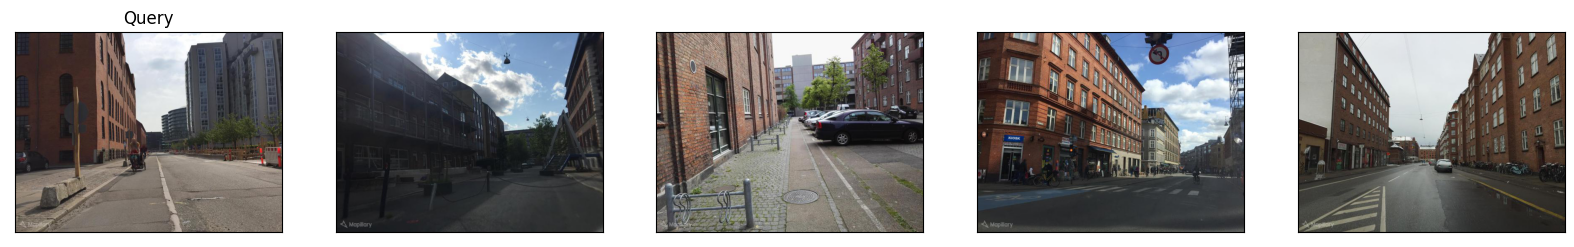

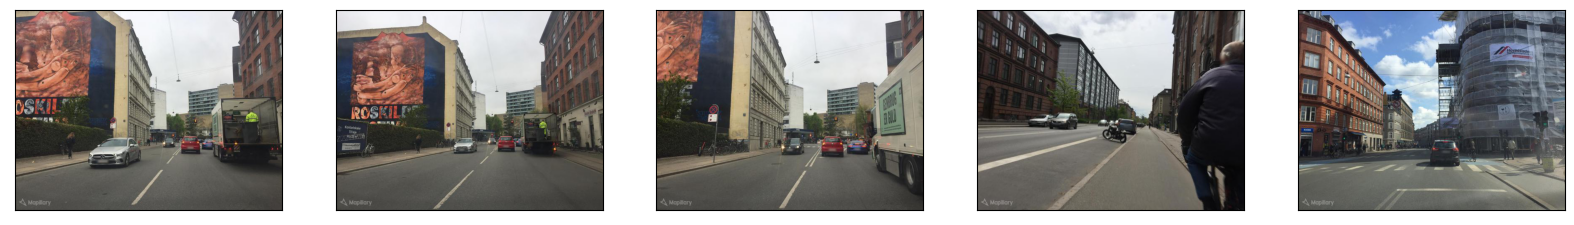

#########


In [91]:
# for i in range(20):
plot_image(900,df,4)

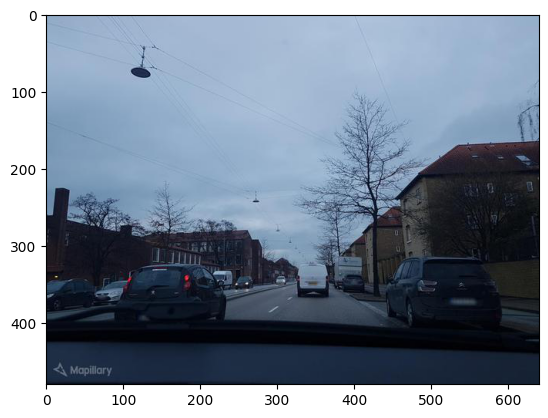

In [59]:
plt.imshow(plt.imread("FIR/msls/train_val/cph/database/images/NKvvcvtlSd5Hu81foZI2-w.jpg"))

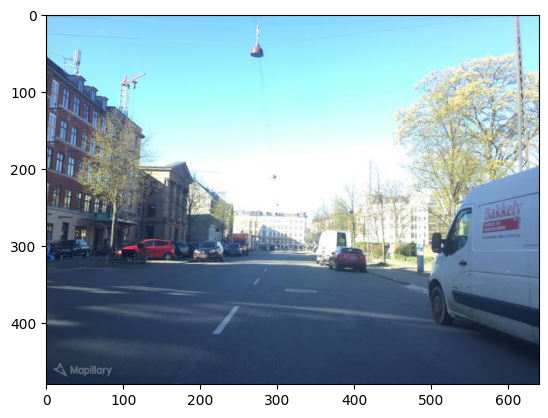

In [58]:
plt.imshow(plt.imread(query))